In [ ]:
import os
print(os.listdir("/content"))


['.config', 'sample_data']


[Feature filtering]
    Kept 204 features starting with: ['LE__original_', 'RE__original_'].
    Example kept cols (first 15): ['LE__original_shape2D_Elongation', 'LE__original_shape2D_MajorAxisLength', 'LE__original_shape2D_MaximumDiameter', 'LE__original_shape2D_MeshSurface', 'LE__original_shape2D_MinorAxisLength', 'LE__original_shape2D_Perimeter', 'LE__original_shape2D_PerimeterSurfaceRatio', 'LE__original_shape2D_PixelSurface', 'LE__original_shape2D_Sphericity', 'LE__original_firstorder_10Percentile', 'LE__original_firstorder_90Percentile', 'LE__original_firstorder_Energy', 'LE__original_firstorder_Entropy', 'LE__original_firstorder_InterquartileRange', 'LE__original_firstorder_Kurtosis']
    LE kept: 102
    RE kept: 102

[1] Dataset size
    Rows (samples):   1811
    Features:         204
    Class counts:     {np.int64(0): np.int64(909), np.int64(1): np.int64(902)}   (0/1)


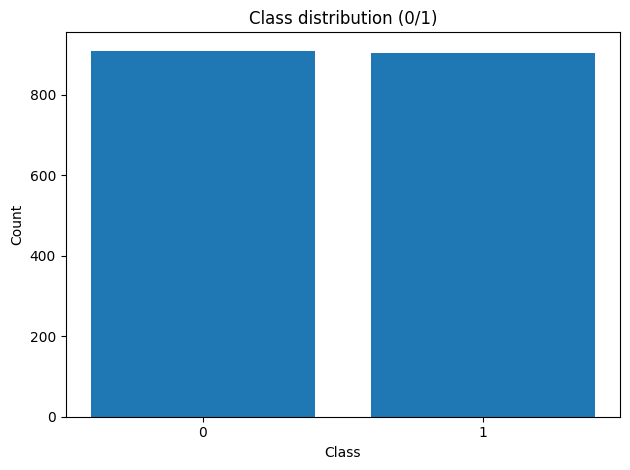


[1b] Duplicate row check
    Exact duplicate rows (features identical): 0
    Duplicate rows including outcome: 0
    Near-duplicate rows (rounded to 5 decimals): 0

[2] Missing values per feature
    Features with missing values: 0 / 204
    Saved: missing_values_per_feature_LE_RE_original.csv


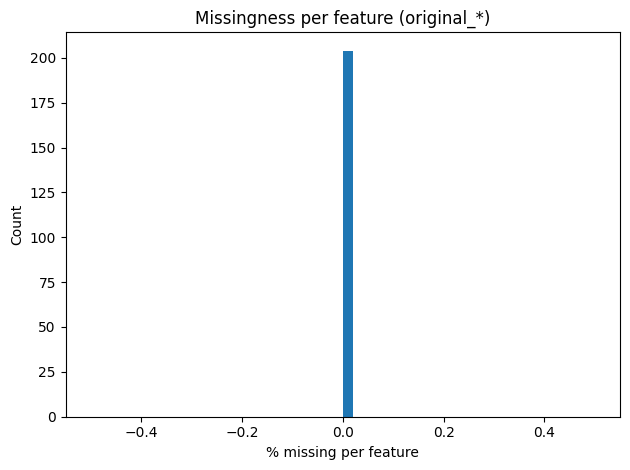


[3] Variance
    Low-variance features (< 0.01): 0 / 204


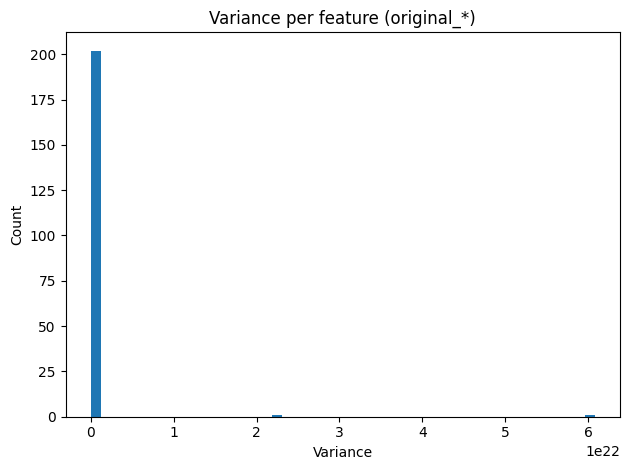


[4] Feature scale heterogeneity (before normalization)
    Mean summary: min=-5.64e+04, median=7.51, max=1.34e+11
    Std  summary: min=0.12, median=5.96, max=2.47e+11


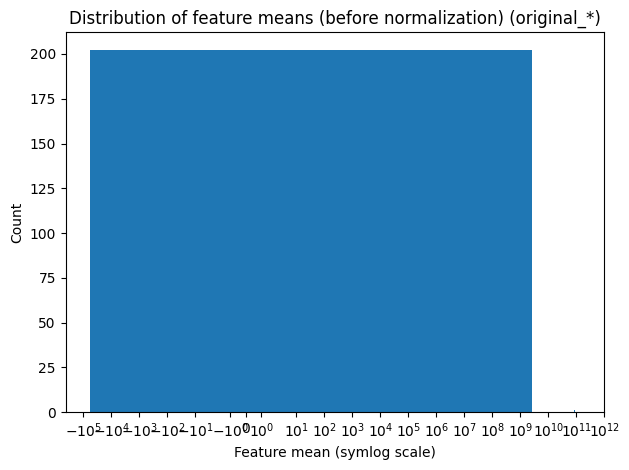

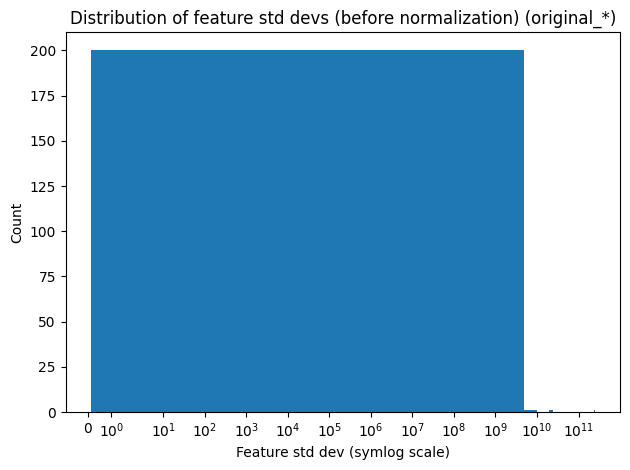


[5] After Z-score normalization
    Mean summary: min=-1.05e-15, median=7.36e-19, max=9.73e-16
    Std  summary: min=1, median=1, max=1
    Features with |mean| > 0.1: 0 / 204
    Features with std outside [0.8, 1.2]: 0 / 204


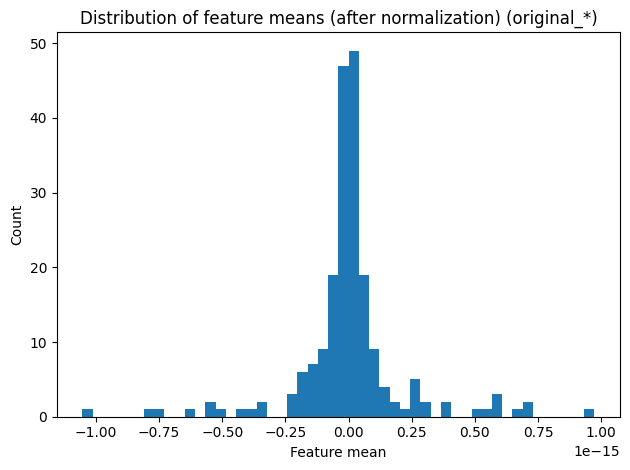

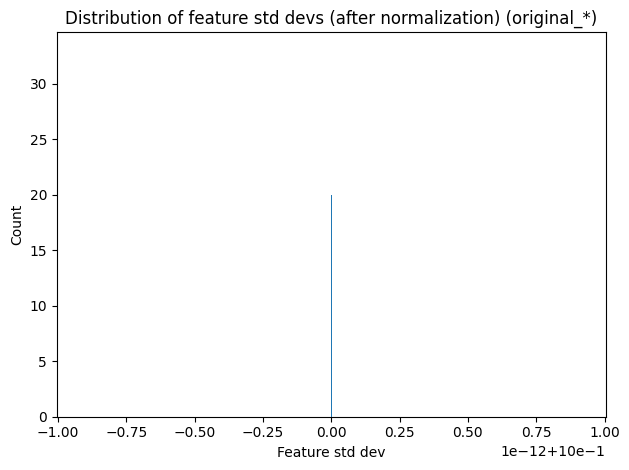


[6] Correlation redundancy (Spearman)
    Total feature pairs: 20706
    Pairs with |rho| > 0.85: 1868 (9.02%)


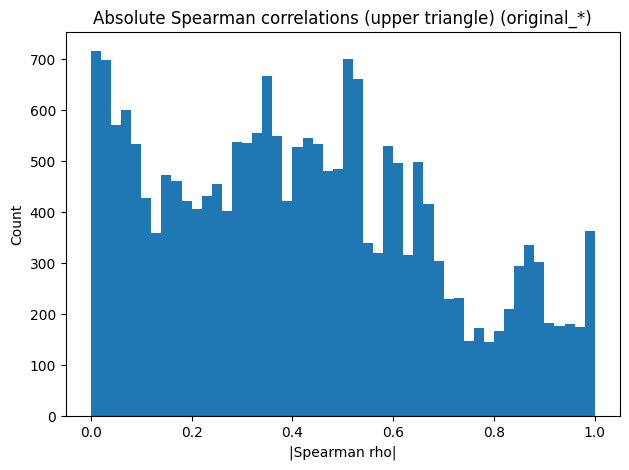


[7] Evidence of signal (univariate)
    ANOVA F-score summary: min=0.0011, median=7.82, max=213


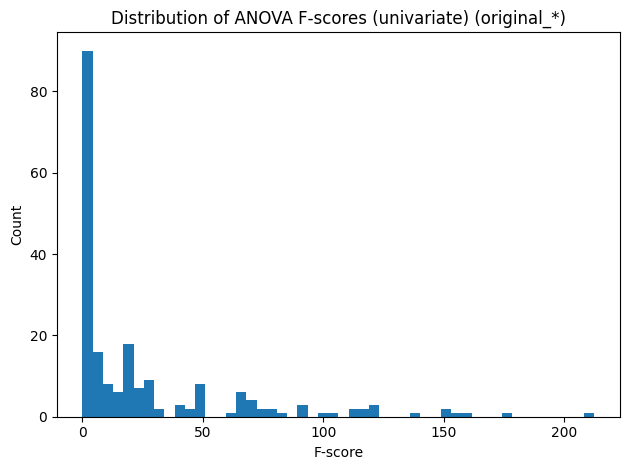


[8] Low-dimensional projection (3D PCA)
    PCA explained variance: PC1=24.67%, PC2=17.15%, PC3=10.35%


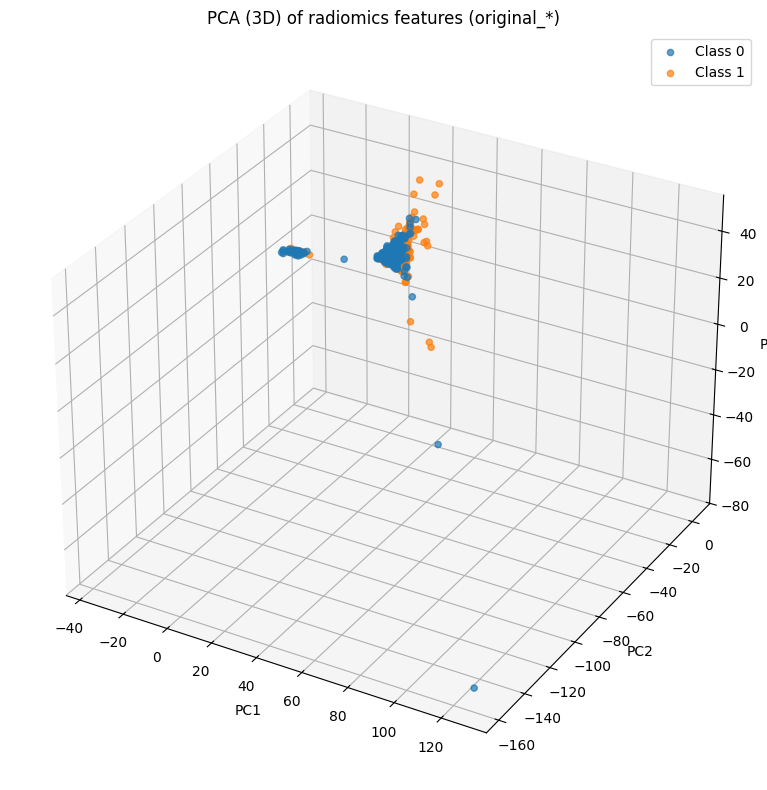


Top 10 features contributing to PC1 (positive loadings):
RE__original_glszm_ZoneEntropy                   0.111602
LE__original_glrlm_RunEntropy                    0.111438
LE__original_glszm_ZoneEntropy                   0.111346
RE__original_glrlm_RunEntropy                    0.110982
RE__original_firstorder_Entropy                  0.110856
RE__original_gldm_DependenceEntropy              0.109889
LE__original_firstorder_Maximum                  0.109746
RE__original_glcm_SumEntropy                     0.109714
RE__original_glcm_JointEntropy                   0.109602
LE__original_firstorder_MeanAbsoluteDeviation    0.109306
Name: PC1, dtype: float64

Top 10 features contributing to PC1 (negative loadings):
LE__original_glcm_Imc1                                -0.038395
RE__original_glcm_ClusterShade                        -0.038134
RE__original_glcm_Imc1                                -0.016178
LE__original_glcm_ClusterShade                        -0.014202
LE__original_shape2D_P

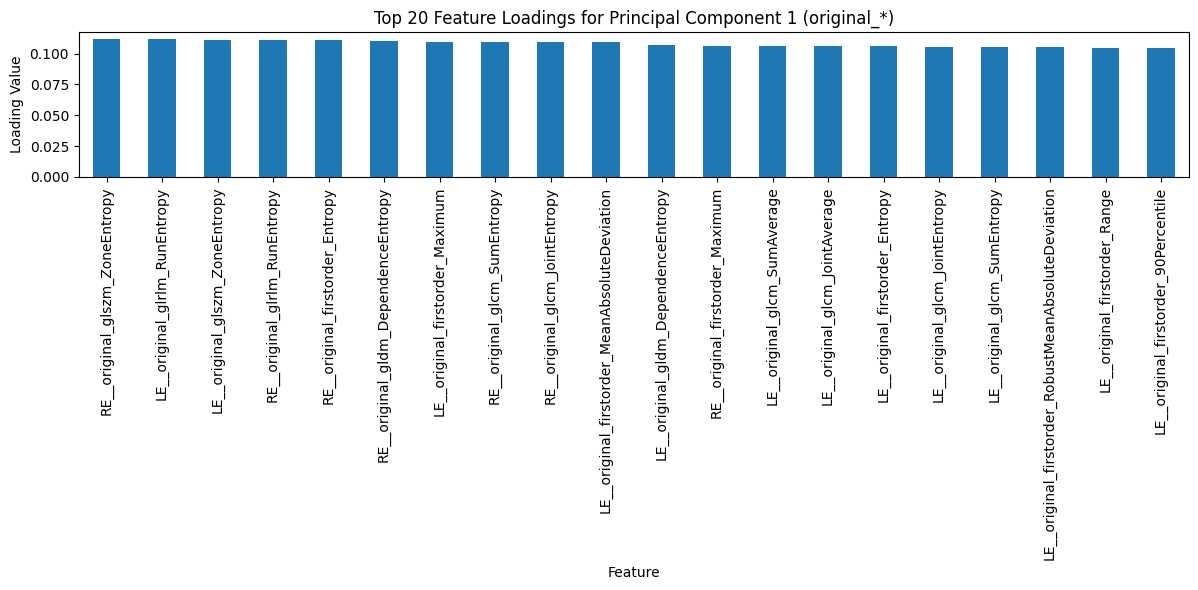

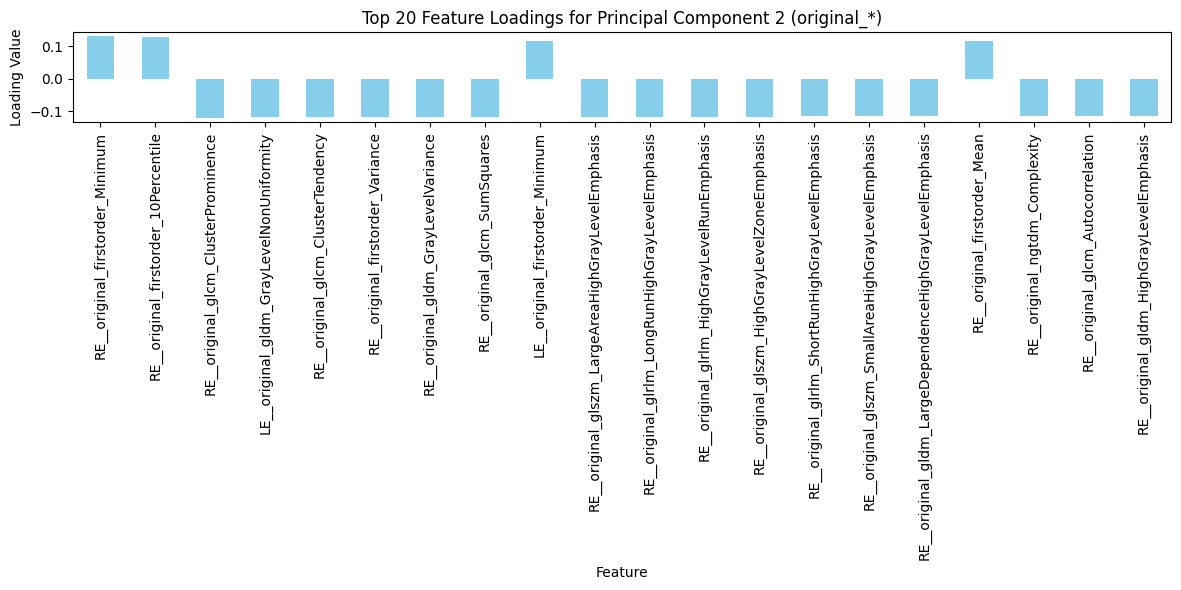


===== Radiomics Feature Summary (improved) =====
 Side   Family  Count
   LE logsigma    372
   LE original    102
   LE  wavelet    186
OTHER    other      2
   RE logsigma    372
   RE original    102
   RE  wavelet    186

Total columns: 1322
Total radiomics features counted: 1322


In [ ]:
"""
Minimal Radiomics EDA Checklist (full script, start-to-finish)

NOW RUNS ON: LE__original_* AND RE__original_* FEATURES ONLY

Includes:
1) Dataset size + class balance (+ bar chart)
1b) Duplicate row checks (exact + near-duplicates)
2) Missing values per feature (full listing + CSV export + histogram)
3) Variance per feature (+ histogram + low-variance count)
4) Feature scale heterogeneity (means/stds before normalization) with symlog plots
5) After Z-score normalization: check means~0, stds~1 (+ histograms)
6) Correlation redundancy: histogram of abs(Spearman rho) + % pairs > 0.85
7) Evidence of some signal: ANOVA F-score distribution (optional single-feature AUC)
8) Low-dimensional projection: 3D PCA scatter colored by class + PCA loadings inspection

Assumptions:
- Input is a CSV with radiomics features + an outcome column.
- Outcome is binary (0/1 or benign/malignant).
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Enables 3D plotting via Matplotlib's "projection='3d'".
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

# -----------------------------
# USER SETTINGS
# -----------------------------

# Path to your radiomics feature CSV
CSV_PATH = "/content/train_merged_LE_RE.csv"     # <-- change to your path

# Name of the outcome/label column in the CSV
OUTCOME_COL = "outcome"               # <-- change if needed

# Columns to drop if present
DROP_COLS = ["Unnamed: 0"]            # <-- columns to drop if present

# Heuristics for “problematic” features
LOW_VARIANCE_THRESHOLD = 0.01  # variance below this indicates near-constant features
CORR_THRESHOLD = 0.85          # “high correlation” redundancy cutoff

# If outcome is strings, set which label should be treated as positive (optional)
POSITIVE_LABEL = "malignant"

# Set True if you want to compute single-feature AUCs (slower)
COMPUTE_SINGLE_FEATURE_AUC = False

# Near-duplicate check tolerance: rounding decimals
NEAR_DUP_ROUND_DECIMALS = 5

# Visualization settings
HIST_BINS = 50

# -----------------------------
# FEATURE FAMILY SETTINGS (NEW)
# -----------------------------
# Run BOTH LE + RE originals at the same time (STRICT: requires trailing underscore)
ORIGINAL_PREFIXES = ["LE__original_", "RE__original_"]

# -----------------------------
# HELPERS
# -----------------------------

# Drop columns that exist; ignore those that don't.
def safe_drop_cols(df: pd.DataFrame, cols):
    cols_present = [c for c in cols if c in df.columns]
    return df.drop(columns=cols_present) if cols_present else df

# Convert outcome column into a clean 0/1 numpy array.
def ensure_binary_labels(y: pd.Series):
    """Return y as 0/1 numpy array. Handles numeric or string labels."""
    y = y.copy()
    # Case A: numeric outcomes already (e.g., 0/1)
    if pd.api.types.is_numeric_dtype(y):
        y_unique = pd.unique(y.dropna())
        if len(y_unique) > 2:
            raise ValueError(f"Outcome has >2 unique values: {y_unique}")
        return y.astype(int).to_numpy()
    # Case B: outcomes are strings/categoricals (e.g., 'benign', 'malignant')
    else:
        y_str = y.astype(str).to_numpy()
        le = LabelEncoder()
        y_enc = le.fit_transform(y_str)
        # Must be binary classification
        if len(le.classes_) != 2:
            raise ValueError(f"Outcome has {len(le.classes_)} classes: {le.classes_}")

        # If the positive label exists, force it to map to 1
        if POSITIVE_LABEL in le.classes_:
            pos_idx = np.where(le.classes_ == POSITIVE_LABEL)[0][0]
            if pos_idx == 0:
                y_enc = 1 - y_enc
        return y_enc

# Plots a histogram of the data.
def plot_hist(data, title, xlabel, bins=HIST_BINS, xscale=None):
    plt.figure()
    plt.hist(data, bins=bins)
    if xscale is not None:
        plt.xscale(xscale)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def plot_bar(labels, counts, title, xlabel="Class", ylabel="Count"):
    plt.figure()
    plt.bar(labels, counts)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# NEW: keep only LE__original_* and RE__original_* features (STRICT + case-insensitive)
def keep_original_features(X: pd.DataFrame, prefixes):
    cols = X.columns.astype(str)

    # allow a single string OR a list/tuple
    if isinstance(prefixes, str):
        prefixes = [prefixes]

    prefixes_lower = [p.lower() for p in prefixes]

    keep = []
    for c in cols:
        cl = c.lower()
        # STRICT: must start with LE__original_ or RE__original_ (case-insensitive)
        if any(cl.startswith(p) for p in prefixes_lower):
            keep.append(c)

    return X[keep], keep

# -----------------------------
# LOAD DATA
# -----------------------------
df = pd.read_csv(CSV_PATH)
df = safe_drop_cols(df, DROP_COLS)

# Check that the outcome/label column is present
if OUTCOME_COL not in df.columns:
    raise ValueError(
        f"Outcome column '{OUTCOME_COL}' not found. "
        f"Available cols (first 20): {list(df.columns)[:20]}"
    )

y_raw = df[OUTCOME_COL]                 # outcome (target labels)
X = df.drop(columns=[OUTCOME_COL])      # features

# Keep only numeric features
X = X.select_dtypes(include=[np.number])

# Convert the outcome labels into binary values (0 and 1)
y = ensure_binary_labels(y_raw)

# -----------------------------
# FILTER TO ORIGINAL FEATURES (NEW)
# -----------------------------
X, original_cols = keep_original_features(X, ORIGINAL_PREFIXES)

if X.shape[1] == 0:
    raise ValueError(
        f"No features found starting with any of: {ORIGINAL_PREFIXES}. "
        f"Check your column naming. Example columns: {list(df.columns)[:30]}"
    )

print("[Feature filtering]")
print(f"    Kept {len(original_cols)} features starting with: {ORIGINAL_PREFIXES}.")
print(f"    Example kept cols (first 15): {original_cols[:15]}")
print(f"    LE kept: {sum(c.lower().startswith('le__original_') for c in original_cols)}")
print(f"    RE kept: {sum(c.lower().startswith('re__original_') for c in original_cols)}")

# -----------------------------
# 1) Dataset size + class balance
# -----------------------------
n_rows, n_features = X.shape
print("\n[1] Dataset size")
print(f"    Rows (samples):   {n_rows}")
print(f"    Features:         {n_features}")

classes, counts = np.unique(y, return_counts=True)
print(f"    Class counts:     {dict(zip(classes, counts))}   (0/1)")

plot_bar(labels=[str(c) for c in classes],
         counts=counts,
         title="Class distribution (0/1)")

# -----------------------------
# 1b) Duplicate row check
# -----------------------------
print("\n[1b] Duplicate row check")

# Exact duplicates across features only
dup_feat_mask = X.duplicated(keep=False)
n_dup_feat = int(dup_feat_mask.sum())
print(f"    Exact duplicate rows (features identical): {n_dup_feat}")

# If duplicates exist, print some example row indices
if n_dup_feat > 0:
    dup_indices = X.index[dup_feat_mask].tolist()
    print(f"    Example duplicate indices (first 20): {dup_indices[:20]}")

# Exact duplicates including outcome
df_full = pd.concat([X, pd.Series(y, name="outcome")], axis=1)
dup_full_mask = df_full.duplicated(keep=False)
n_dup_full = int(dup_full_mask.sum())
print(f"    Duplicate rows including outcome: {n_dup_full}")

# Near-duplicate check via rounding
X_rounded = X.round(NEAR_DUP_ROUND_DECIMALS)
near_dup_mask = X_rounded.duplicated(keep=False)
n_near_dup = int(near_dup_mask.sum())
print(f"    Near-duplicate rows (rounded to {NEAR_DUP_ROUND_DECIMALS} decimals): {n_near_dup}")

# -----------------------------
# 2) Missing values per feature (detailed)
# -----------------------------
print("\n[2] Missing values per feature")

missing_count = X.isna().sum(axis=0)
missing_pct = (missing_count / len(X)) * 100.0

missing_summary = pd.DataFrame({
    "missing_count": missing_count,
    "missing_pct": missing_pct
}).sort_values("missing_pct", ascending=False)

missing_features = missing_summary[missing_summary["missing_count"] > 0]
print(f"    Features with missing values: {missing_features.shape[0]} / {n_features}")

if missing_features.shape[0] > 0:
    print("\n    Top 15 features by missing percentage:")
    print(missing_features.head(15))

# Save full table for documentation (tagged)
out_name = "missing_values_per_feature_LE_RE_original.csv"
missing_summary.to_csv(out_name)
print(f"    Saved: {out_name}")

plot_hist(missing_pct.values,
          title="Missingness per feature (original_*)",
          xlabel="% missing per feature")

# Drop features that are 100% missing
completely_missing_cols = missing_summary[missing_summary['missing_pct'] == 100.0].index
if not completely_missing_cols.empty:
    print(f"    Dropping {len(completely_missing_cols)} features that are 100% missing.")
    X = X.drop(columns=completely_missing_cols)
    n_rows, n_features = X.shape

# -----------------------------
# 3) Variance per feature (+ low variance count)
# -----------------------------
print("\n[3] Variance")

feature_var = X.var(axis=0, ddof=0, skipna=True)
low_var_mask = feature_var < LOW_VARIANCE_THRESHOLD
print(f"    Low-variance features (< {LOW_VARIANCE_THRESHOLD}): {int(low_var_mask.sum())} / {n_features}")

plot_hist(feature_var.values,
          title="Variance per feature (original_*)",
          xlabel="Variance")

# -----------------------------
# 4) Feature scale heterogeneity (before normalization)
# -----------------------------
print("\n[4] Feature scale heterogeneity (before normalization)")

feature_means = X.mean(axis=0, skipna=True)
feature_stds = X.std(axis=0, ddof=0, skipna=True)

print(f"    Mean summary: min={feature_means.min():.3g}, median={feature_means.median():.3g}, max={feature_means.max():.3g}")
print(f"    Std  summary: min={feature_stds.min():.3g}, median={feature_stds.median():.3g}, max={feature_stds.max():.3g}")

plot_hist(feature_means.values,
          title="Distribution of feature means (before normalization) (original_*)",
          xlabel="Feature mean (symlog scale)",
          xscale="symlog")

plot_hist(feature_stds.values,
          title="Distribution of feature std devs (before normalization) (original_*)",
          xlabel="Feature std dev (symlog scale)",
          xscale="symlog")

# -----------------------------
# Impute missing values (for downstream correlation/PCA/ANOVA)
# -----------------------------
X_imputed = X.copy()
X_imputed = X_imputed.fillna(X_imputed.median(numeric_only=True))

# -----------------------------
# 5) After normalization: means ~ 0, stds ~ 1
# -----------------------------
print("\n[5] After Z-score normalization")

scaler = StandardScaler()
Xz = scaler.fit_transform(X_imputed)
Xz_df = pd.DataFrame(Xz, columns=X_imputed.columns)

z_means = Xz_df.mean(axis=0)
z_stds = Xz_df.std(axis=0, ddof=0)

print(f"    Mean summary: min={z_means.min():.3g}, median={z_means.median():.3g}, max={z_means.max():.3g}")
print(f"    Std  summary: min={z_stds.min():.3g}, median={z_stds.median():.3g}, max={z_stds.max():.3g}")

print(f"    Features with |mean| > 0.1: {int((np.abs(z_means) > 0.1).sum())} / {n_features}")
print(f"    Features with std outside [0.8, 1.2]: {int(((z_stds < 0.8) | (z_stds > 1.2)).sum())} / {n_features}")

plot_hist(z_means.values,
          title="Distribution of feature means (after normalization) (original_*)",
          xlabel="Feature mean")

plot_hist(z_stds.values,
          title="Distribution of feature std devs (after normalization) (original_*)",
          xlabel="Feature std dev")

# -----------------------------
# 6) Correlation redundancy
# -----------------------------
print("\n[6] Correlation redundancy (Spearman)")

corr = Xz_df.corr(method="spearman")
corr_vals = corr.to_numpy()

upper_idx = np.triu_indices_from(corr_vals, k=1)
abs_corr_upper = np.abs(corr_vals[upper_idx])

n_pairs = abs_corr_upper.size
n_over = int((abs_corr_upper > CORR_THRESHOLD).sum())
pct_over = (n_over / n_pairs) * 100.0 if n_pairs > 0 else 0.0

print(f"    Total feature pairs: {n_pairs}")
print(f"    Pairs with |rho| > {CORR_THRESHOLD}: {n_over} ({pct_over:.2f}%)")

plot_hist(abs_corr_upper,
          title="Absolute Spearman correlations (upper triangle) (original_*)",
          xlabel="|Spearman rho|")

# -----------------------------
# 7) Evidence of some signal
# -----------------------------
print("\n[7] Evidence of signal (univariate)")

F, p = f_classif(Xz_df.values, y)

finite_F = F[np.isfinite(F)]
fill_val = float(np.max(finite_F)) if finite_F.size else 0.0
F = np.nan_to_num(F, nan=0.0, posinf=fill_val, neginf=0.0)

print(f"    ANOVA F-score summary: min={np.min(F):.3g}, median={np.median(F):.3g}, max={np.max(F):.3g}")

plot_hist(F,
          title="Distribution of ANOVA F-scores (univariate) (original_*)",
          xlabel="F-score")

if COMPUTE_SINGLE_FEATURE_AUC:
    print("    Computing single-feature AUCs (this can take a while)...")
    aucs = []

    for col in Xz_df.columns:
        vals = Xz_df[col].values
        if np.all(vals == vals[0]):
            aucs.append(0.5)
        else:
            try:
                aucs.append(roc_auc_score(y, vals))
            except ValueError:
                aucs.append(0.5)

    aucs = np.array(aucs)
    print(f"    Single-feature AUC summary: min={aucs.min():.3g}, median={np.median(aucs):.3g}, max={aucs.max():.3g}")

    plot_hist(aucs,
              title="Distribution of single-feature AUCs (original_*)",
              xlabel="AUC")

# -----------------------------
# 8) Low-dimensional projection: 3D PCA
# -----------------------------
print("\n[8] Low-dimensional projection (3D PCA)")

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(Xz_df.values)

explained = pca.explained_variance_ratio_ * 100
print(f"    PCA explained variance: PC1={explained[0]:.2f}%, PC2={explained[1]:.2f}%, PC3={explained[2]:.2f}%")

# --- Plotly (optional) ---
# If you're in Colab/Jupyter, you can keep this cell magic.
# If you're in a .py script, comment out the %pip line and pip-install in your env.
%pip install plotly
import plotly.express as px

dfp = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
dfp["class"] = y.astype(str)

fig = px.scatter_3d(dfp, x="PC1", y="PC2", z="PC3", color="class", opacity=0.7)
fig.show()

# --- Matplotlib 3D ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_pca[y == 0, 0], X_pca[y == 0, 1], X_pca[y == 0, 2],
    label="Class 0", alpha=0.7
)
ax.scatter(
    X_pca[y == 1, 0], X_pca[y == 1, 1], X_pca[y == 1, 2],
    label="Class 1", alpha=0.7
)

ax.set_title("PCA (3D) of radiomics features (original_*)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# PCA loadings inspection
# -----------------------------
import matplotlib.pyplot as plt

feature_names = Xz_df.columns

pca_loadings = pd.DataFrame(
    pca.components_,
    columns=feature_names,
    index=[f'PC{i+1}' for i in range(pca.n_components)]
)

print("\nTop 10 features contributing to PC1 (positive loadings):")
print(pca_loadings.loc['PC1'].nlargest(10))

print("\nTop 10 features contributing to PC1 (negative loadings):")
print(pca_loadings.loc['PC1'].nsmallest(10))

print("\nTop 10 features contributing to PC2 (positive loadings):")
print(pca_loadings.loc['PC2'].nlargest(10))

print("\nTop 10 features contributing to PC2 (negative loadings):")
print(pca_loadings.loc['PC2'].nsmallest(10))

# -----------------------------
# Visualization: PC1 loadings (Top 20)
# -----------------------------
plt.figure(figsize=(12, 6))
sorted_pc1_loadings = pca_loadings.loc['PC1'].abs().sort_values(ascending=False)
top_20_pc1 = pca_loadings.loc['PC1'][sorted_pc1_loadings.index[:20]]
top_20_pc1.plot(kind='bar')
plt.title('Top 20 Feature Loadings for Principal Component 1 (original_*)')
plt.xlabel('Feature')
plt.ylabel('Loading Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# -----------------------------
# Visualization: PC2 loadings (Top 20)
# -----------------------------
plt.figure(figsize=(12, 6))
sorted_pc2_loadings = pca_loadings.loc['PC2'].abs().sort_values(ascending=False)
top_20_pc2 = pca_loadings.loc['PC2'][sorted_pc2_loadings.index[:20]]
top_20_pc2.plot(kind='bar', color='skyblue')
plt.title('Top 20 Feature Loadings for Principal Component 2 (original_*)')
plt.xlabel('Feature')
plt.ylabel('Loading Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

from collections import defaultdict
import pandas as pd

counts = defaultdict(int)

for col in df.columns:
    c = str(col).lower()

    side = "OTHER"
    if c.startswith("le__"):
        side = "LE"
    elif c.startswith("re__"):
        side = "RE"

    family = "other"
    if "__original_" in c:
        family = "original"
    elif "wavelet-" in c:
        family = "wavelet"
    elif "log-sigma" in c or "logsigma" in c:
        family = "logsigma"

    key = f"{side}_{family}"
    counts[key] += 1

summary_rows = []
for k, v in sorted(counts.items()):
    side, family = k.split("_", 1)
    summary_rows.append({
        "Side": side,
        "Family": family,
        "Count": v
    })

summary_df = pd.DataFrame(summary_rows).sort_values(["Side", "Family"])

print("\n===== Radiomics Feature Summary (improved) =====")
print(summary_df.to_string(index=False))
print("\nTotal columns:", len(df.columns))
print("Total radiomics features counted:", summary_df["Count"].sum())


In [ ]:

# WEEK 2 - INITIAL MODELLING + EVALUATION + ERROR INSPECTION
# Drop these CELLS/SECTIONS at the END of your current EDA script.
# Uses the SAME X (filtered LE/RE original features) and y.

# CELL 1/5 — Imports + Settings + Sanity checks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve,
    average_precision_score
)

# -----------------------------
# USER SETTINGS (MODELLING)
# -----------------------------
N_SPLITS = 5
RANDOM_STATE = 42

# Nested CV avoids optimistic bias (recommended)
USE_NESTED_CV = True

# Use these k values for SelectKBest
K_GRID = [10, 25, 50, 100, 200]

# Logistic regression tuning grid
LOGREG_C_GRID = [0.01, 0.1, 1.0, 10.0, 100.0]

# Random forest tuning grid (keep modest to avoid long runtime)
RF_N_ESTIMATORS = [300, 600]
RF_MAX_DEPTH = [None, 5, 10]
RF_MIN_SAMPLES_LEAF = [1, 2, 5]

# Probability threshold for confusion matrix and error inspection
THRESHOLD = 0.5

# Output files for documentation
RESULTS_CSV = "week2_model_results_summary.csv"
FOLD_RESULTS_CSV = "week2_model_results_per_fold.csv"
MISCLASS_CSV = "week2_misclassified_samples.csv"

# Optional: checkpoint file so you don't lose progress if runtime crashes
CHECKPOINT_PKL = "week2_checkpoint.pkl"

# -----------------------------
# BASIC SANITY CHECKS
# -----------------------------
if "X" not in globals() or "y" not in globals():
    raise ValueError("X and y were not found. Run the EDA cells first so X and y exist.")

if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)

y = np.asarray(y).astype(int)

print("\n-------")
print("WEEK 2 - MODELLING START")
print("-------")
print(f"Samples: {X.shape[0]} | Features: {X.shape[1]}")
classes, counts = np.unique(y, return_counts=True)
print(f"Class counts (0/1): {dict(zip(classes, counts))}")




WEEK 2 - MODELLING START
Samples: 1811 | Features: 204
Class counts (0/1): {np.int64(0): np.int64(909), np.int64(1): np.int64(902)}


In [ ]:

# CELL 2/5 — Helpers (includes the correction)

def compute_metrics_from_proba(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)

    out = {
        "AUC": roc_auc_score(y_true, y_proba),
        "AP": average_precision_score(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall_Sensitivity": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
    }

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    out["Specificity"] = specificity
    out["TN"] = tn
    out["FP"] = fp
    out["FN"] = fn
    out["TP"] = tp
    return out

# FIXED: aggregate ONLY numeric columns (avoid 'model' strings + 'best_params' dicts)
def summarize_fold_metrics(fold_rows):
    dfm = pd.DataFrame(fold_rows)

    numeric_cols = dfm.select_dtypes(include=[np.number]).columns
    summary = dfm[numeric_cols].agg(["mean", "std"]).T
    summary.columns = ["mean", "std"]

    return dfm, summary

def save_checkpoint(path, **kwargs):
    import pickle
    with open(path, "wb") as f:
        pickle.dump(kwargs, f)

def load_checkpoint(path):
    import pickle, os
    if not os.path.exists(path):
        return None
    with open(path, "rb") as f:
        return pickle.load(f)


In [ ]:

# CELL 3/5 — Pipelines + Nested CV evaluation + Save results

preprocess_and_select = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("selectk", SelectKBest(score_func=f_classif))
])

logreg_pipe = Pipeline(steps=[
    ("prep", preprocess_and_select),
    ("clf", LogisticRegression(
        solver="liblinear",
        max_iter=5000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

rf_pipe = Pipeline(steps=[
    ("prep", preprocess_and_select),
    ("clf", RandomForestClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

logreg_grid = {
    "prep__selectk__k": K_GRID,
    "clf__C": LOGREG_C_GRID
}

rf_grid = {
    "prep__selectk__k": K_GRID,
    "clf__n_estimators": RF_N_ESTIMATORS,
    "clf__max_depth": RF_MAX_DEPTH,
    "clf__min_samples_leaf": RF_MIN_SAMPLES_LEAF
}

models = [
    ("LogReg_SelectKBest", logreg_pipe, logreg_grid),
    ("RandomForest_SelectKBest", rf_pipe, rf_grid)
]

outer_cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
inner_cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

all_model_summaries = []
all_fold_rows = []

best_model_name = None
best_model_auc = -np.inf

# If you crashed earlier, you can resume from checkpoint (optional)
ckpt = load_checkpoint(CHECKPOINT_PKL)
if ckpt is not None and ckpt.get("stage") == "after_nested":
    print(f"\n[Checkpoint] Found {CHECKPOINT_PKL}. Skipping nested CV and loading results.")
    all_model_summaries = ckpt["all_model_summaries"]
    all_fold_rows = ckpt["all_fold_rows"]
    best_model_name = ckpt["best_model_name"]
    best_model_auc = ckpt["best_model_auc"]
else:
    for name, pipe, grid in models:
        print("\n-----------------------------")
        print(f"Model: {name}")
        print("-----------------------------")

        fold_rows = []

        if USE_NESTED_CV:
            for fold_i, (tr_idx, te_idx) in enumerate(outer_cv.split(X, y), start=1):
                X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
                y_tr, y_te = y[tr_idx], y[te_idx]

                search = GridSearchCV(
                    estimator=pipe,
                    param_grid=grid,
                    scoring="roc_auc",
                    cv=inner_cv,
                    n_jobs=-1,
                    refit=True
                )

                search.fit(X_tr, y_tr)
                best_est = search.best_estimator_

                y_proba = best_est.predict_proba(X_te)[:, 1]
                metrics = compute_metrics_from_proba(y_te, y_proba, threshold=THRESHOLD)
                metrics["model"] = name
                metrics["fold"] = fold_i
                metrics["best_params"] = search.best_params_

                fold_rows.append(metrics)

                print(f"Fold {fold_i}: AUC={metrics['AUC']:.3f} | F1={metrics['F1']:.3f} | "
                      f"Recall={metrics['Recall_Sensitivity']:.3f} | Spec={metrics['Specificity']:.3f}")

            fold_df, summary = summarize_fold_metrics(fold_rows)
            mean_auc = float(summary.loc["AUC", "mean"])

            all_fold_rows.extend(fold_rows)

            print("\nNested CV summary (mean ± std):")
            print(summary.loc[["AUC", "AP", "Accuracy", "Precision", "Recall_Sensitivity", "Specificity", "F1"]].to_string())

            print("\nBest params per fold:")
            for _, row in fold_df.iterrows():
                print(f"    Fold {int(row['fold'])}: {row['best_params']}")

            model_summary = {
                "model": name,
                "cv_type": "nested",
                "AUC_mean": summary.loc["AUC", "mean"],
                "AUC_std": summary.loc["AUC", "std"],
                "F1_mean": summary.loc["F1", "mean"],
                "F1_std": summary.loc["F1", "std"],
                "Recall_mean": summary.loc["Recall_Sensitivity", "mean"],
                "Recall_std": summary.loc["Recall_Sensitivity", "std"],
                "Specificity_mean": summary.loc["Specificity", "mean"],
                "Specificity_std": summary.loc["Specificity", "std"],
            }
            all_model_summaries.append(model_summary)

            if mean_auc > best_model_auc:
                best_model_auc = mean_auc
                best_model_name = name

        else:
            search = GridSearchCV(
                estimator=pipe,
                param_grid=grid,
                scoring="roc_auc",
                cv=outer_cv,
                n_jobs=-1,
                refit=True
            )
            search.fit(X, y)

            print("WARNING: Non-nested CV. This can be optimistically biased if used for final reporting.")
            print("Best params (CV on full data):", search.best_params_)
            print("Best CV AUC:", search.best_score_)

            model_summary = {
                "model": name,
                "cv_type": "non_nested",
                "AUC_mean": search.best_score_,
                "AUC_std": np.nan,
                "F1_mean": np.nan,
                "F1_std": np.nan,
                "Recall_mean": np.nan,
                "Recall_std": np.nan,
                "Specificity_mean": np.nan,
                "Specificity_std": np.nan,
            }
            all_model_summaries.append(model_summary)

            if float(search.best_score_) > best_model_auc:
                best_model_auc = float(search.best_score_)
                best_model_name = name

    # Save results tables
    summary_df = pd.DataFrame(all_model_summaries).sort_values("AUC_mean", ascending=False)
    summary_df.to_csv(RESULTS_CSV, index=False)
    print("\nSaved model summary:", RESULTS_CSV)
    print(summary_df.to_string(index=False))

    if len(all_fold_rows) > 0:
        folds_df = pd.DataFrame(all_fold_rows)
        folds_df.to_csv(FOLD_RESULTS_CSV, index=False)
        print("Saved per-fold metrics:", FOLD_RESULTS_CSV)

    print("\nBest model by AUC:", best_model_name, f"(AUC_mean={best_model_auc:.3f})")

    # ------------------------------------------------------------
    # NEW (small): choose ONE tuned parameter set for OOF inspection
    # ------------------------------------------------------------
    from collections import Counter

    def most_common_params_for_model(all_fold_rows, model_name):
        rows = [r for r in all_fold_rows if r["model"] == model_name]
        if len(rows) == 0:
            return None

        # dict -> tuple so Counter can count them
        params_as_tuples = [tuple(sorted(r["best_params"].items())) for r in rows]
        most_common = Counter(params_as_tuples).most_common(1)[0][0]
        return dict(most_common)

    best_common_params = most_common_params_for_model(all_fold_rows, best_model_name)

    print("\n[Chosen params for OOF error inspection]")
    print("Using most common best_params across folds:")
    print(best_common_params)

    # Checkpoint after the heavy nested-CV stage
    save_checkpoint(
        CHECKPOINT_PKL,
        stage="after_nested",
        all_model_summaries=all_model_summaries,
        all_fold_rows=all_fold_rows,
        best_model_name=best_model_name,
        best_model_auc=best_model_auc,
        best_common_params=best_common_params
    )
    print(f"[Checkpoint] Saved: {CHECKPOINT_PKL}")



-----------------------------
Model: LogReg_SelectKBest
-----------------------------
Fold 1: AUC=0.876 | F1=0.822 | Recall=0.829 | Spec=0.813
Fold 2: AUC=0.853 | F1=0.791 | Recall=0.800 | Spec=0.780
Fold 3: AUC=0.867 | F1=0.802 | Recall=0.822 | Spec=0.775
Fold 4: AUC=0.887 | F1=0.832 | Recall=0.839 | Spec=0.824
Fold 5: AUC=0.848 | F1=0.808 | Recall=0.801 | Spec=0.818

Nested CV summary (mean ± std):
                        mean       std
AUC                 0.866335  0.016072
AP                  0.828965  0.025766
Accuracy            0.810044  0.016700
Precision           0.804128  0.019879
Recall_Sensitivity  0.818189  0.017165
Specificity         0.801997  0.022809
F1                  0.811010  0.016111

Best params per fold:
    Fold 1: {'clf__C': 10.0, 'prep__selectk__k': 200}
    Fold 2: {'clf__C': 10.0, 'prep__selectk__k': 100}
    Fold 3: {'clf__C': 10.0, 'prep__selectk__k': 200}
    Fold 4: {'clf__C': 10.0, 'prep__selectk__k': 200}
    Fold 5: {'clf__C': 100.0, 'prep__selectk


ERROR INSPECTION (OOF) - FAST

[OOF uses tuned params from nested CV]
{'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 600, 'prep__selectk__k': 200}
[Checkpoint] Updated: week2_checkpoint.pkl (after OOF proba)
OOF metrics (threshold = 0.50):
AUC                   0.895095
AP                    0.873649
Accuracy              0.813915
Precision             0.795812
Recall_Sensitivity    0.842572
Specificity           0.785479
F1                    0.818525

Confusion matrix (rows=true, cols=pred):
 [[714 195]
 [142 760]]

Classification report:
               precision    recall  f1-score   support

           0      0.834     0.785     0.809       909
           1      0.796     0.843     0.819       902

    accuracy                          0.814      1811
   macro avg      0.815     0.814     0.814      1811
weighted avg      0.815     0.814     0.814      1811



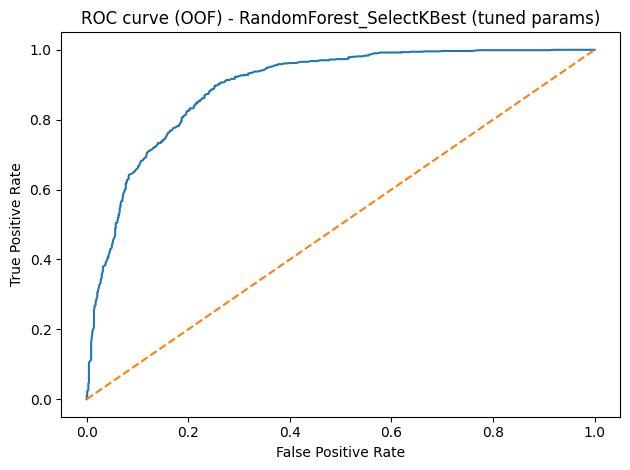

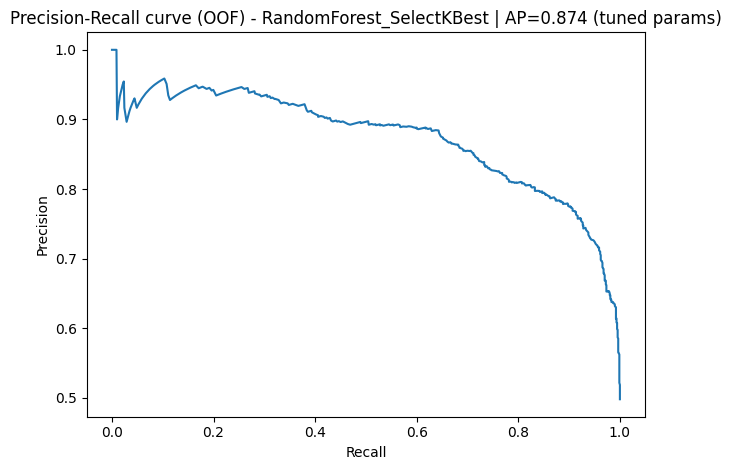

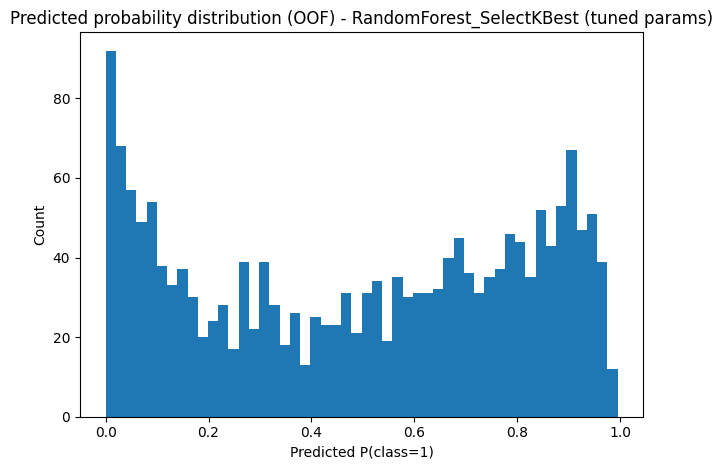


Most uncertain 30 samples (closest to 0.5 probability):
 index  y_true   p1_oof  abs(p-0.5)
  1101       0 0.500000    0.000000
  1410       1 0.500000    0.000000
  1673       0 0.500000    0.000000
   713       1 0.498333    0.001667
  1803       1 0.501667    0.001667
   118       1 0.501667    0.001667
   166       1 0.501667    0.001667
   373       0 0.501667    0.001667
   203       0 0.503333    0.003333
    28       1 0.503333    0.003333
  1688       1 0.503333    0.003333
   873       1 0.503333    0.003333
   406       1 0.503333    0.003333
   685       1 0.503333    0.003333
   521       1 0.496667    0.003333
  1157       1 0.495000    0.005000
  1358       0 0.505000    0.005000
  1677       1 0.495000    0.005000
   196       0 0.493333    0.006667
  1635       0 0.493333    0.006667
   658       0 0.506667    0.006667
  1064       0 0.508333    0.008333
    67       0 0.508333    0.008333
   971       0 0.508333    0.008333
   314       0 0.508333    0.008333
   722 

In [ ]:

# CELL 4/5 — ERROR INSPECTION (OOF) — FAST + robust
# (no GridSearchCV inside cross_val_predict)

print("\n-------")
print("ERROR INSPECTION (OOF) - FAST")
print("-------")

from sklearn.base import clone

if best_model_name is None:
    raise ValueError("No best model was selected. Check earlier outputs.")

best_tuple = [t for t in models if t[0] == best_model_name][0]
best_name, best_pipe, best_grid = best_tuple

# ------------------------------------------------------------
# FIX: use tuned params from CELL 3/5 (most common best_params)
# ------------------------------------------------------------
ckpt = load_checkpoint(CHECKPOINT_PKL)
best_common_params = None if ckpt is None else ckpt.get("best_common_params", None)

fixed_best = clone(best_pipe)

if best_common_params is not None:
    fixed_best = fixed_best.set_params(**best_common_params)
    print("\n[OOF uses tuned params from nested CV]")
    print(best_common_params)
else:
    print("\nWARNING: best_common_params not found in checkpoint.")
    print("OOF will run with the default (untuned) model params. "
          "Run CELL 3/5 first to generate best_common_params.")

# Out-of-fold predicted probabilities (fast: only N_SPLITS fits)
y_oof_proba = cross_val_predict(
    fixed_best,
    X,
    y,
    cv=outer_cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# Save checkpoint after OOF proba computed (so you never have to recompute)
save_checkpoint(
    CHECKPOINT_PKL,
    stage="after_oof_proba",
    all_model_summaries=all_model_summaries,
    all_fold_rows=all_fold_rows,
    best_model_name=best_model_name,
    best_model_auc=best_model_auc,
    y_oof_proba=y_oof_proba,
    best_common_params=best_common_params
)
print(f"[Checkpoint] Updated: {CHECKPOINT_PKL} (after OOF proba)")

# Compute headline metrics from OOF predictions
oof_metrics = compute_metrics_from_proba(y, y_oof_proba, threshold=THRESHOLD)
print("OOF metrics (threshold = %.2f):" % THRESHOLD)
print(pd.Series(oof_metrics)[["AUC","AP","Accuracy","Precision","Recall_Sensitivity","Specificity","F1"]].to_string())

# Confusion matrix and report
y_oof_pred = (y_oof_proba >= THRESHOLD).astype(int)
cm = confusion_matrix(y, y_oof_pred)
print("\nConfusion matrix (rows=true, cols=pred):\n", cm)
print("\nClassification report:\n", classification_report(y, y_oof_pred, digits=3, zero_division=0))

# ROC curve
fpr, tpr, _ = roc_curve(y, y_oof_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC curve (OOF) - {best_model_name} (tuned params)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y, y_oof_proba)
ap = average_precision_score(y, y_oof_proba)
plt.figure()
plt.plot(rec, prec)
plt.title(f"Precision-Recall curve (OOF) - {best_model_name} | AP={ap:.3f} (tuned params)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

# Probability histogram (uncertainty)
plt.figure()
plt.hist(y_oof_proba, bins=50)
plt.title(f"Predicted probability distribution (OOF) - {best_model_name} (tuned params)")
plt.xlabel("Predicted P(class=1)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Identify uncertain cases near decision boundary
uncertainty_distance = np.abs(y_oof_proba - 0.5)
uncertain_idx = np.argsort(uncertainty_distance)[:30]
print("\nMost uncertain 30 samples (closest to 0.5 probability):")
print(pd.DataFrame({
    "index": uncertain_idx,
    "y_true": y[uncertain_idx],
    "p1_oof": y_oof_proba[uncertain_idx],
    "abs(p-0.5)": uncertainty_distance[uncertain_idx]
}).sort_values("abs(p-0.5)").to_string(index=False))

# Misclassified samples table (for documentation)
mis_mask = (y_oof_pred != y)
mis_idx = np.where(mis_mask)[0]

mis_df = pd.DataFrame({
    "index": mis_idx,
    "y_true": y[mis_idx],
    "y_pred": y_oof_pred[mis_idx],
    "p1_oof": y_oof_proba[mis_idx],
})

mis_df["error_type"] = np.where(
    (mis_df["y_true"] == 1) & (mis_df["y_pred"] == 0),
    "FN",
    "FP"
)

mis_df["confidence"] = np.where(mis_df["y_pred"] == 1, mis_df["p1_oof"], 1 - mis_df["p1_oof"])
mis_df = mis_df.sort_values("confidence", ascending=False)

mis_df.to_csv(MISCLASS_CSV, index=False)
print(f"\nMisclassified samples saved: {MISCLASS_CSV}")
print("Top 20 high-confidence errors:")
print(mis_df.head(20).to_string(index=False))


In [ ]:

# CELL 5/5 — Weekly update summary (printable)

print("\n-------")
print("WEEKLY UPDATE SUMMARY (AUTO)")
print("-------")

print("- Data scope: LE__original_ + RE__original_ features only (strict prefix filtering).")
print(f"- Samples: {X.shape[0]}, Features: {X.shape[1]}")
print(f"- Class distribution (0/1): {dict(zip(classes, counts))}")

print(f"- Best model (by AUC): {best_model_name}")

# NEW: report which params were used for OOF
ckpt = load_checkpoint(CHECKPOINT_PKL)
best_common_params = None if ckpt is None else ckpt.get("best_common_params", None)
print(f"- OOF params: {best_common_params if best_common_params is not None else 'default/untuned (best_common_params not found)'}")

print(f"- OOF AUC: {oof_metrics['AUC']:.3f}, OOF F1: {oof_metrics['F1']:.3f}, "
      f"OOF Recall: {oof_metrics['Recall_Sensitivity']:.3f}, OOF Specificity: {oof_metrics['Specificity']:.3f}")

print(f"- Total misclassifications: {len(mis_df)} (FN={int((mis_df['error_type']=='FN').sum())}, "
      f"FP={int((mis_df['error_type']=='FP').sum())})")

print("- Uncertainty: inspect probability histogram and the most uncertain cases (closest to 0.5).")

print("\nFiles produced for documentation:")
print(f"- {RESULTS_CSV}")
print(f"- {FOLD_RESULTS_CSV}" if len(all_fold_rows) > 0 else "- (no per-fold file in non-nested mode)")
print(f"- {MISCLASS_CSV}")
print(f"- {CHECKPOINT_PKL} (checkpoint for resuming)")

print("\nWEEK 2 - MODELLING DONE")



WEEKLY UPDATE SUMMARY (AUTO)
- Data scope: LE__original_ + RE__original_ features only (strict prefix filtering).
- Samples: 1811, Features: 204
- Class distribution (0/1): {np.int64(0): np.int64(909), np.int64(1): np.int64(902)}
- Best model (by AUC): RandomForest_SelectKBest
- OOF params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 600, 'prep__selectk__k': 200}
- OOF AUC: 0.895, OOF F1: 0.819, OOF Recall: 0.843, OOF Specificity: 0.785
- Total misclassifications: 337 (FN=142, FP=195)
- Uncertainty: inspect probability histogram and the most uncertain cases (closest to 0.5).

Files produced for documentation:
- week2_model_results_summary.csv
- week2_model_results_per_fold.csv
- week2_misclassified_samples.csv
- week2_checkpoint.pkl (checkpoint for resuming)

WEEK 2 - MODELLING DONE
